In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import tqdm.notebook as tqdm
from sklearn.model_selection import train_test_split
import tensorflow as tf
from sklearn.metrics import confusion_matrix as cm, classification_report as cr

/Users/juhisinghrathore/opt/anaconda3/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2024-05-16 14:20:01.748633: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
df_train = pd.read_csv('FairFace/train_labels.csv')
df_train['split'] = 'train'
df_train['file'] = 'FairFace/' + df_train.file
df_test = pd.read_csv('FairFace/val_labels.csv')
df_test['file'] = 'FairFace/' + df_test.file
df_test['split'] = 'test'
df = pd.concat([df_train, df_test])


df = df.drop(columns=['service_test', 'race', 'gender'])

In [5]:
df

,file,age,split
0,FairFace/train/1.jpg,50-59,train
1,FairFace/train/2.jpg,30-39,train
2,FairFace/train/3.jpg,3-9,train
3,FairFace/train/4.jpg,20-29,train
4,FairFace/train/5.jpg,20-29,train
...,...,...,...
10949,FairFace/val/10950.jpg,30-39,test
10950,FairFace/val/10951.jpg,50-59,test
10951,FairFace/val/10952.jpg,60-69,test
10952,FairFace/val/10953.jpg,20-29,test


In [6]:
import pandas as pd

# Assuming `df` is your DataFrame
unique_age_values = df['age'].unique()

print(unique_age_values)


['50-59' '30-39' '3-9' '20-29' '40-49' '10-19' '60-69' '0-2'
 'more than 70']


In [7]:
data = {'age': ['50-59', '30-39', '3-9', '20-29', '40-49', '10-19', '60-69', '0-2', 'more than 70']}


# Define the mapping dictionary for labels
label_mapping = {
    '0-2': 0,
    '3-9': 1,
    '10-19': 2,
    '20-29': 3,
    '30-39': 4,
    '40-49': 5,
    '50-59': 6,
    '60-69': 7,
    'more than 70': 8
}

# Map the 'age' column using the mapping dictionary
df['age'] = df['age'].map(label_mapping)

df

,file,age,split
0,FairFace/train/1.jpg,6,train
1,FairFace/train/2.jpg,4,train
2,FairFace/train/3.jpg,1,train
3,FairFace/train/4.jpg,3,train
4,FairFace/train/5.jpg,3,train
...,...,...,...
10949,FairFace/val/10950.jpg,4,test
10950,FairFace/val/10951.jpg,6,test
10951,FairFace/val/10952.jpg,7,test
10952,FairFace/val/10953.jpg,3,test


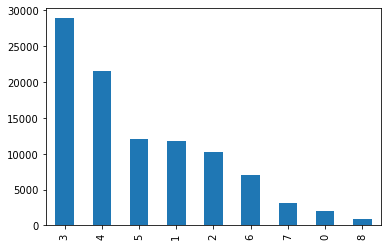

In [8]:
df['age'].value_counts().plot.bar()
plt.show()
plt.close()

In [9]:
df_train = df[df.split == 'train'].drop(columns=['split'])
df_train, df_val = train_test_split(df_train, test_size=0.1, random_state=0, shuffle=True)
df_test = df[df.split == 'test'].drop(columns=['split'])

In [10]:
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.optimizers import SGD
# from tensorflow.keras.layers import Dense
# from tensorflow.keras.models import Model

# base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224,224,3), pooling='avg')

# for layer in base_model.layers:
#     layer.trainable = False

# base = Dense(2, activation='softmax')(base_model.output)
# model = Model(base_model.input, base)
# model.compile(loss='categorical_crossentropy',
#              optimizer=SGD(learning_rate=0.1, momentum=0.9, decay=0.5), 
#              metrics=['accuracy'])

2024-05-16 14:21:08.230488: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


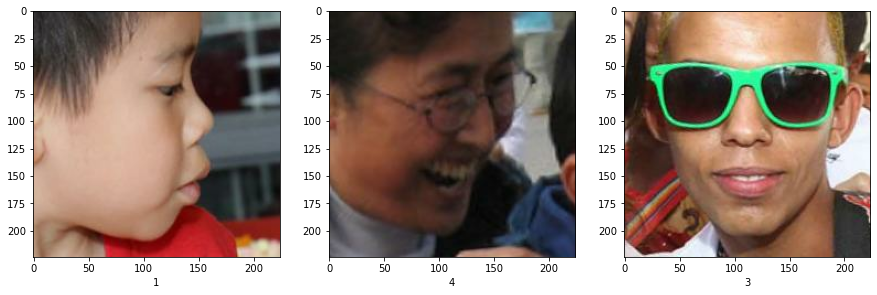

In [11]:
IMG_SIZE = 224
AUTOTUNE = tf.data.AUTOTUNE
BATCH_SIZE = 224
NUM_CLASSES = 9

# Dataset creation
y_train = tf.keras.utils.to_categorical(df_train.age, num_classes=NUM_CLASSES)
y_test = tf.keras.utils.to_categorical(df_test.age, num_classes=NUM_CLASSES)
y_val = tf.keras.utils.to_categorical(df_val.age, num_classes=NUM_CLASSES)


train_ds = tf.data.Dataset.from_tensor_slices((df_train.file, y_train)).shuffle(len(y_train))
val_ds = tf.data.Dataset.from_tensor_slices((df_val.file, y_val))
test_ds = tf.data.Dataset.from_tensor_slices((df_test.file, y_test))

assert len(train_ds) == len(df_train.file) == len(df_train.age)
assert len(val_ds) == len(df_val.file) == len(df_val.age)
assert len(test_ds) == len(df_test.file) == len(df_test.age)

# Read files
def map_fn(path, label):
    image = tf.io.decode_jpeg(tf.io.read_file(path))
    image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
    return image, label

# Read files
train_ds = train_ds.map(lambda path, lbl: (tf.io.decode_jpeg(tf.io.read_file(path)), lbl), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda path, lbl: (tf.io.decode_jpeg(tf.io.read_file(path)), lbl), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda path, lbl: (tf.io.decode_jpeg(tf.io.read_file(path)), lbl), num_parallel_calls=AUTOTUNE)

# Batch and resize after batch, then prefetch
train_ds = train_ds.map(lambda imgs, lbls: (tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE)), lbls), num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(lambda imgs, lbls: (tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE)), lbls), num_parallel_calls=AUTOTUNE)
test_ds = test_ds.map(lambda imgs, lbls: (tf.image.resize(imgs, (IMG_SIZE, IMG_SIZE)), lbls), num_parallel_calls=AUTOTUNE)

train_ds = train_ds.batch(BATCH_SIZE)
val_ds = val_ds.batch(BATCH_SIZE)
test_ds = test_ds.batch(BATCH_SIZE)

# Performance enchancement - cache, batch, prefetch
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.prefetch(buffer_size=AUTOTUNE)

# Display some
imgs, lbls = list(train_ds.take(1))[0]
n = 3
fig, ax = plt.subplots(1, n, figsize=(5*n, 5))
for i, (img, lbl) in enumerate(zip(imgs[:n], lbls[:n])):
    ax[i].imshow(img.numpy().astype('uint8'))
    ax[i].set(xlabel=lbl.numpy().argmax())

plt.show()

In [12]:
print(NUM_CLASSES)

9


In [13]:
import tensorflow as tf

data_augmentation = tf.keras.Sequential([tf.keras.layers.Lambda(lambda x: x)])

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input

base_model = tf.keras.applications.MobileNetV2(
    include_top=False,
    weights='imagenet',
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    pooling="avg"
)

base_model.trainable = False


In [14]:
LEARNING_RATE = 0.001

inputs = x = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(x)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(units=NUM_CLASSES, activation="softmax")(x)

model = tf.keras.Model(inputs=inputs, outputs=x)

model.compile(
    optimizer=tf.optimizers.Adam(LEARNING_RATE),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 11,529 (45.04 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [15]:
EPOCHS = 15

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_delta=0.0001),
    tf.keras.callbacks.ModelCheckpoint(
        'weights.weights.h5',  # Update filepath to end with .weights.h5
        monitor='val_loss', 
        verbose=1, 
        save_best_only=True, 
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=15, verbose=1, restore_best_weights=True)
]

history = model.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    callbacks=callbacks,
    epochs=EPOCHS,
)

# model.load_weights('weights.h5')

model.evaluate(test_ds)

Epoch 1/15


I0000 00:00:1715849498.703627  238574 service.cc:145] XLA service 0x600002549a00 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1715849498.704865  238574 service.cc:153]   StreamExecutor device (0): Host, Default Version
2024-05-16 14:21:38.708166: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
I0000 00:00:1715849498.925139  238574 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3080 - loss: 1.7945
Epoch 1: val_loss improved from inf to 1.55236, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 1631s 5s/step - accuracy: 0.3081 - loss: 1.7942 - val_accuracy: 0.3751 - val_loss: 1.5524 - learning_rate: 0.0010
Epoch 2/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3752 - loss: 1.5520
Epoch 2: val_loss improved from 1.55236 to 1.52160, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 1609s 5s/step - accuracy: 0.3752 - loss: 1.5520 - val_accuracy: 0.3824 - val_loss: 1.5216 - learning_rate: 0.0010
Epoch 3/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3888 - loss: 1.5153
Epoch 3: val_loss improved from 1.52160 to 1.49706, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 1629s 5s/step - accuracy: 0.3888 - loss: 1.5153 - val_accuracy: 0.3920 - val_loss: 1.4971 - learning_rate: 0.0010
Epoch 4/15
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.3968 

[1.4751352071762085, 0.40487492084503174]

In [16]:
y_true, y_pred = [], []
for imgs, lbls in test_ds.take(len(test_ds)):
    y_true.append(lbls.numpy())
    y_pred.append(model.predict(imgs))

y_pred = np.argmax(np.concatenate(y_pred), axis=1) 
y_true = np.argmax(np.concatenate(y_true), axis=1)   

print(cr(y_pred=y_pred, y_true=y_true))
print(cm(y_pred=y_pred, y_true=y_true))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 738ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 733ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 736ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 746ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 745ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 762ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 759ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 773ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 774ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 769ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 770ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 766ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 768ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 758ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 757ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 757ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 757ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 763ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 761ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 753ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 760ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

2024-05-16 21:32:19.864616: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


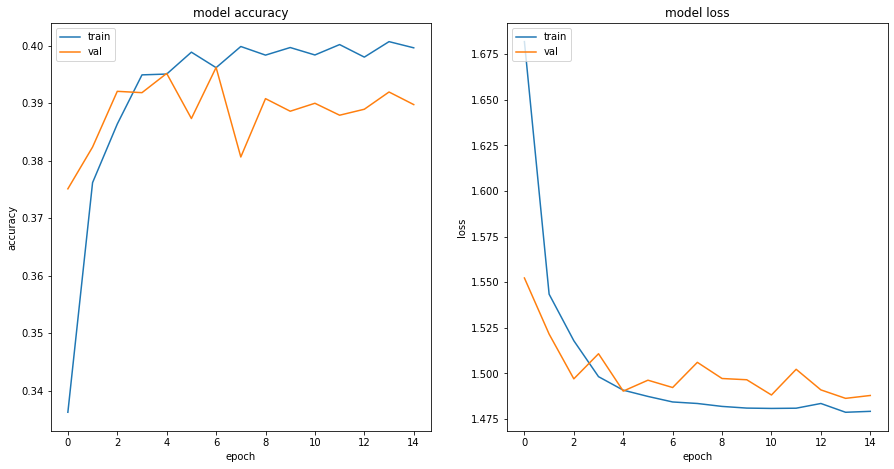

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))

ax1.plot(history.history['accuracy'])
ax1.plot(history.history['val_accuracy'])
ax1.set_title('model accuracy')
ax1.set(ylabel='accuracy', xlabel='epoch')
ax1.legend(['train', 'val'], loc='upper left')

ax2.plot(history.history['loss'])
ax2.plot(history.history['val_loss'])
ax2.set_title('model loss')
ax2.set(ylabel='loss', xlabel='epoch')
ax2.legend(['train', 'val'], loc='upper left')
plt.show()

In [18]:
FINE_TUNE_EPOCHS = 5

base_model.trainable = True
print("Number of layers in the base model: ", len(base_model.layers))
fine_tune_at = 35
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable =  False

model.compile(
    optimizer=tf.optimizers.Adam(LEARNING_RATE / 10),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

print(model.summary())

callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', factor=0.1, patience=10, verbose=1, mode='min', min_delta=0.0001),
    tf.keras.callbacks.ModelCheckpoint(
        'weights.weights.h5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', min_delta=0, patience=15, verbose=1, restore_best_weights=True)
]


history_fine = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=history.epoch[-1]+FINE_TUNE_EPOCHS,
    initial_epoch=history.epoch[-1],
    callbacks=callbacks,
    verbose=1,
)

# model.save_weights('weights_fine.tf')

model.evaluate(test_ds)


Number of layers in the base model:  155


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 9)              │        11,529 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,269,513 (8.66 MB)

 Trainable params: 2,209,673 (8.43 MB)

 Non-trainable params: 59,840 (233.75 KB)

None
Epoch 15/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 17s/step - accuracy: 0.3901 - loss: 1.4992 
Epoch 15: val_loss improved from inf to 1.85338, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 6185s 18s/step - accuracy: 0.3902 - loss: 1.4988 - val_accuracy: 0.3343 - val_loss: 1.8534 - learning_rate: 1.0000e-04
Epoch 16/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.5391 - loss: 1.0856 
Epoch 16: val_loss did not improve from 1.85338
349/349 ━━━━━━━━━━━━━━━━━━━━ 4541s 13s/step - accuracy: 0.5391 - loss: 1.0856 - val_accuracy: 0.3035 - val_loss: 2.3348 - learning_rate: 1.0000e-04
Epoch 17/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.6074 - loss: 0.9204 
Epoch 17: val_loss improved from 1.85338 to 1.61088, saving model to weights.weights.h5
349/349 ━━━━━━━━━━━━━━━━━━━━ 4695s 13s/step - accuracy: 0.6074 - loss: 0.9204 - val_accuracy: 0.3997 - val_loss: 1.6109 - learning_rate: 1.0000e-04
Epoch 18/19
349/349 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.

[1.3440425395965576, 0.4402045011520386]

In [19]:
y_true, y_pred = [], []
for imgs, lbls in test_ds.take(len(test_ds)):
    y_true.append(lbls.numpy())
    y_pred.append(model.predict(imgs))

y_pred = np.argmax(np.concatenate(y_pred), axis=1) 
y_true = np.argmax(np.concatenate(y_true), axis=1)   

print(cr(y_pred=y_pred, y_true=y_true))
print(cm(y_pred=y_pred, y_true=y_true))

7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 711ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 701ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 705ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 691ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 703ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 696ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 713ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 717ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 704ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 711ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 710ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 714ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 709ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 706ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 706ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 708ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 703ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 714ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 714ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 713ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 

2024-05-17 04:36:46.789485: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


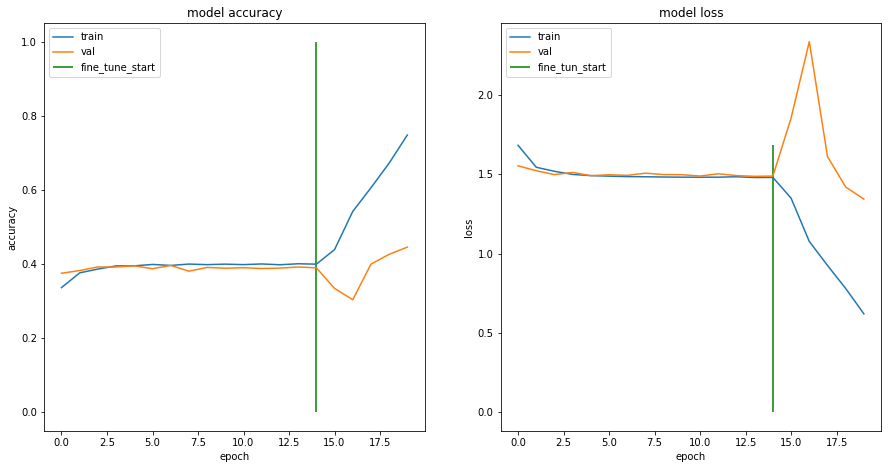

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 7.5))
acc = history.history['accuracy'] + history_fine.history['accuracy']
val_acc = history.history['val_accuracy'] + history_fine.history['val_accuracy']
loss = history.history['loss'] + history_fine.history['loss']
val_loss = history.history['val_loss'] + history_fine.history['val_loss']

ax1.plot(acc)
ax1.plot(val_acc)
ax1.set_title('model accuracy')
ax1.set(ylabel='accuracy', xlabel='epoch')
ax1.vlines(history.epoch[-1], 0, 1, colors='green')
ax1.legend(['train', 'val', 'fine_tune_start'], loc='upper left')


ax2.plot(loss)
ax2.plot(val_loss)
ax2.set_title('model loss')
ax2.set(ylabel='loss', xlabel='epoch')
ax2.vlines(history.epoch[-1], 0, max(loss), colors='green')
ax2.legend(['train', 'val', 'fine_tun_start'], loc='upper left')

plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 706ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 701ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 708ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 715ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 711ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 707ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 712ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 709ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 672ms/step


2024-05-17 04:37:32.775408: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


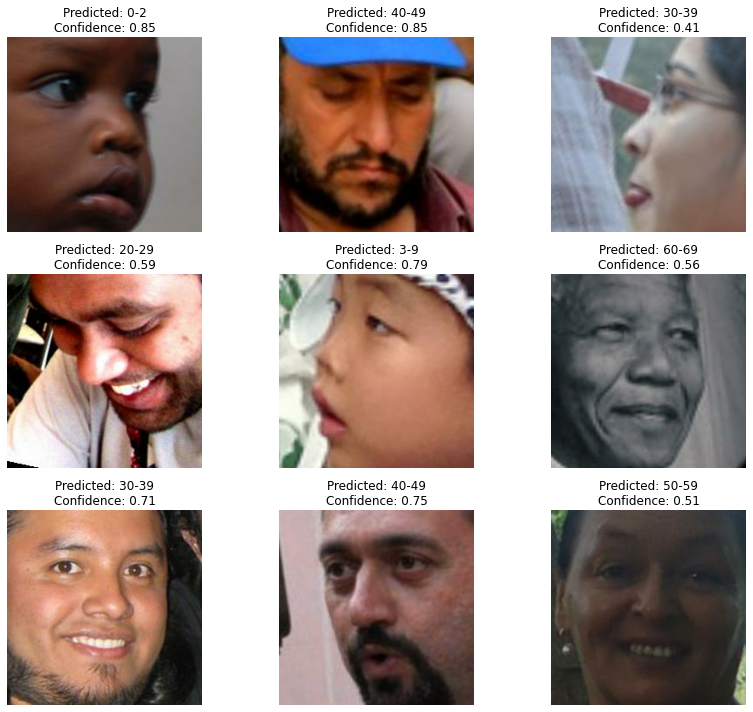

In [21]:
def display_images_with_predictions(model, val_ds, num_images=9):
    class_labels = { 0:'0-2',
    1:'3-9',
    2:'10-19',
    3:'20-29',
    4:'30-39',
    5:'40-49',
    6:'50-59',
    7:'60-69',
    8:'more than 70'}

    plt.figure(figsize=(12, 10))
    for i, (imgs, lbls) in enumerate(val_ds.take(num_images)):
        plt.subplot(3, 3, i + 1)
        plt.imshow(imgs[0].numpy().astype("uint8"))  # Assuming the batch size is 1
        plt.axis('off')
        prediction = model.predict(imgs)[0]
        predicted_label_idx = np.argmax(prediction)
        confidence = prediction[predicted_label_idx]
        predicted_label = class_labels[predicted_label_idx]
        plt.title(f"Predicted: {predicted_label}\nConfidence: {confidence:.2f}")
    plt.tight_layout()
    plt.show()

# Call the function to display images with predictions
display_images_with_predictions(model, train_ds)